# Critical lines and caustics of the binary lens

The critical lines and caustics of the binary lens are determined by solving numerically the equation

$$
\frac{\partial z_s}{\partial z^*}=e^{i\phi}
$$

for any $\phi \in [0,2\pi)$.

The equation can be turned into a fourth order complex polynomial, of which we shall find the roots:

$$
z^4-z^2(2z_1^{*2}+e^{i\phi})-zz_1^*2(m_1-m_2)e^{i\phi}+z_1^{*2}(z_1^{*2}-e^{i\phi})=0
$$

For each $\phi$ there are up to $4$ roots (critical points). By using the lens equation, these can be mapped on the source plane to derive the caustics:

$$
z_{cau}=z_{crit}-\frac{m_1}{z_{crit}^*-z_1^*}-\frac{m_2}{z_{crit}^*-z_2^*} \;.
$$

The following code shows how to calculate the critical lines and the caustics of a binary lens and produces an image illustrating some possibile caustic topologies.

## A class for binary lenses

We begin by importing some relevant packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

We need to specify the properties of the binary lens. In addition, we will need to be able to change these properties in order to study different caustic configurations. Therefore, it is convenient to build a class. Since we will need to compute the Einstein radius, and this method is already implemented in the ```point_lens``` class from the previous python example, we will use this class which is now included in the ```microlensing.py``` module.

In [10]:
import microlensing as ml

class binary_lens(object):
    """
    The object binary_lens will be built using the mass of the first lens, the mass ratio
    and the distance between the lenses in units of the equivalent Einstein radius.
    By convention, we will place the two lenses on the real axis and will put the origin of 
    the reference frame in the midpoint between the two masses.
    """
    def __init__(self,dl=5.0,ds=8,m1=1.0,q=1.0,d=2.0,t0=0.0,y0=0.1,theta=np.pi/4):
        self.z1=complex(d/2.0,0.0)
        self.q=q
        self.dl=dl
        self.ds=ds
        m2=m1/q
        self.mtot=m1+m2
        self.m1=m1/self.mtot
        self.m2=m2/self.mtot
        ps = ml.point_source(ds=ds)
        pl = ml.point_lens(ps=ps, mass=m1+m2, dl=dl)
        self.thetaE=pl.EinsteinRadius()
        self.tE=pl.EinsteinCrossTime()
        self.t0=t0
        self.y0=y0
        self.theta=theta

    """
    This function finds the lens critical lines and caustics
    """
    def CritCau(self,ncpt=10000):
        # set the phase vector
        phi_=np.linspace(0,2.*np.pi,ncpt)
        
        x=[]
        y=[]
        xs=[]
        ys=[]

        # we need to find the roots of our fourth order polynomial for each value of phi
        for i in range(phi_.size):
            phi=phi_[i]
            # the coefficients of the complex polynomial
            coefficients = [1.0,0.0,-2*np.conj(self.z1)**2-np.exp(1j*phi),
                            -np.conj(self.z1)*2*(self.m1-self.m2)*np.exp(1j*phi),
                            np.conj(self.z1)**2*(np.conj(self.z1)**2-np.exp(1j*phi))]
            # use the numpy function roots to find the roots of the polynomial
            z=np.roots(coefficients) # these are the critical points!
    
            # use the lens equation (complex form) to map the critical points on the source plane 
            zs=z-self.m1/(np.conj(z)-np.conj(self.z1))-self.m2/((np.conj(z)-np.conj(-self.z1))) # these are the caustics!
    
            # append critical and caustic points
            x.append(z.real)
            y.append(z.imag)
            xs.append(zs.real)
            ys.append(zs.imag)
        
        return(np.array(x),np.array(y),np.array(xs),np.array(ys))
    
    """
    This function finds the images of a source at a given position with respect to the lens
    """
    def Images(self,ys1,ys2):
        zs=complex(ys1,ys2)
        m=0.5*(self.m1+self.m2)
        Dm=(self.m2-self.m1)/2.0

        c5=self.z1**2-np.conj(zs)**2
        c4=-2*m*np.conj(zs)+zs*np.conj(zs)**2-2*Dm*self.z1-zs*self.z1**2
        c3=4.0*m*zs*np.conj(zs)+4.0*Dm*np.conj(zs)*self.z1+2.0*np.conj(zs)**2*self.z1**2-2.0*self.z1**4
        c2=4.0*m**2*zs+4.0*m*Dm*self.z1-4.0*Dm*zs*np.conj(zs)*self.z1-2.0*zs*np.conj(zs)**2\
                *self.z1**2+4.0*Dm*self.z1**3+2.0*zs*self.z1**4
        c1=-8.0*m*Dm*zs*self.z1-4.0*Dm**2*self.z1**2-4.0*m**2*self.z1**2-4.0*m*zs*np.conj(zs)*self.z1**2\
                -4.0*Dm*np.conj(zs)*self.z1**3-np.conj(zs)**2*self.z1**4+self.z1**6
        c0=self.z1**2*(4.0*Dm**2*zs+4.0*m*Dm*self.z1+4.0*Dm*zs*np.conj(zs)*self.z1+\
                   2.0*m*np.conj(zs)*self.z1**2+zs*np.conj(zs)**2*self.z1**2-2*Dm*self.z1**3-zs*self.z1**4)

        coefficients=[c5,c4,c3,c2,c1,c0]

        images=np.roots(coefficients)
        #print images
        # now, we need to drop the spurious solutions. This can be done by checking which solutions 
        # satisfy the lens equation
        z2=-self.z1
        deltazs=zs-(images-self.m1/(np.conj(images)-np.conj(self.z1))-self.m2/(np.conj(images)-np.conj(z2)))
        #print np.abs(deltazs)
        return (np.array([images.real[np.abs(deltazs)<1e-3]]),np.array([images.imag[np.abs(deltazs)<1e-3]]))
    
    def SourcePos(self,t):
        p=(t-self.t0)/self.tE.value
        zreal=np.cos(self.theta)*p+np.sin(self.theta)*self.y0
        zimag=-np.sin(self.theta)*p+np.cos(self.theta)*self.y0
        #z=complex(zreal,zimag)
        return(zreal,zimag)
    
    def detA(self,z):
        z2=-self.z1
        deta=1-np.abs(self.m1/(np.conj(z)-np.conj(self.z1))**2+self.m2/(np.conj(z)-np.conj(z2))**2)
        return(deta)
    
    def Magnification(self,t):
        ys1,ys2=self.SourcePos(t)
        xi1,xi2=self.Images(ys1,ys2)
        images=xi1+1j*xi2
        mu=1.0/self.detA(images)
        return(np.abs(mu).sum())
    
    def LightCurve(self,times):
        p=(times-self.t0)/self.tE.value
        mu=[]
        for t in times:
            mu.append(self.Magnification(t))
        #mu=np.array(mu)
        return(p,mu)
        
    
    """
    Some utilities
    """
    def getPos(self):
        return(self.z1)
        
    def gettE(self):
        return(self.tE)
    
    def getThetaE(self):
        return(self.thetaE)
    
    def WideIntTrans(self):
        dwi=((self.m1)**(1./3.)+(self.m2)**(1./3.))**(3./2.)
        return(dwi)
    
    def IntCloseTrans(self):
        dic=((self.m1)**(1./3.)+(self.m2)**(1./3.))**(-3./4.)
        return(dic)



Now we make the plot: we will plot
* a wide system
* a transition between a wide and an intermediate system
* an intermediate system
* a transition between intermediate and close systems 
* a close system
Thus a 5x2 panels (left side for critical lines and right side for caustics) where 
$m_1$, $m_2$ (and $q$) will be the same, while $d$ will decrease from 1.5 to 0.1.

The first transition occurs when 
$$
d_{WI}=(m_1^{1/3}+m_2^{1/3})^{3/2}
$$
The second when
$$
d_{IC}=(m_1^{1/3}+m_2^{1/3})^{-3/4}
$$

/Users/massimo/anaconda/envs/python2x/lib/python2.7/site-packages/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/massimo/anaconda/envs/python2x/lib/python2.7/site-packages/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


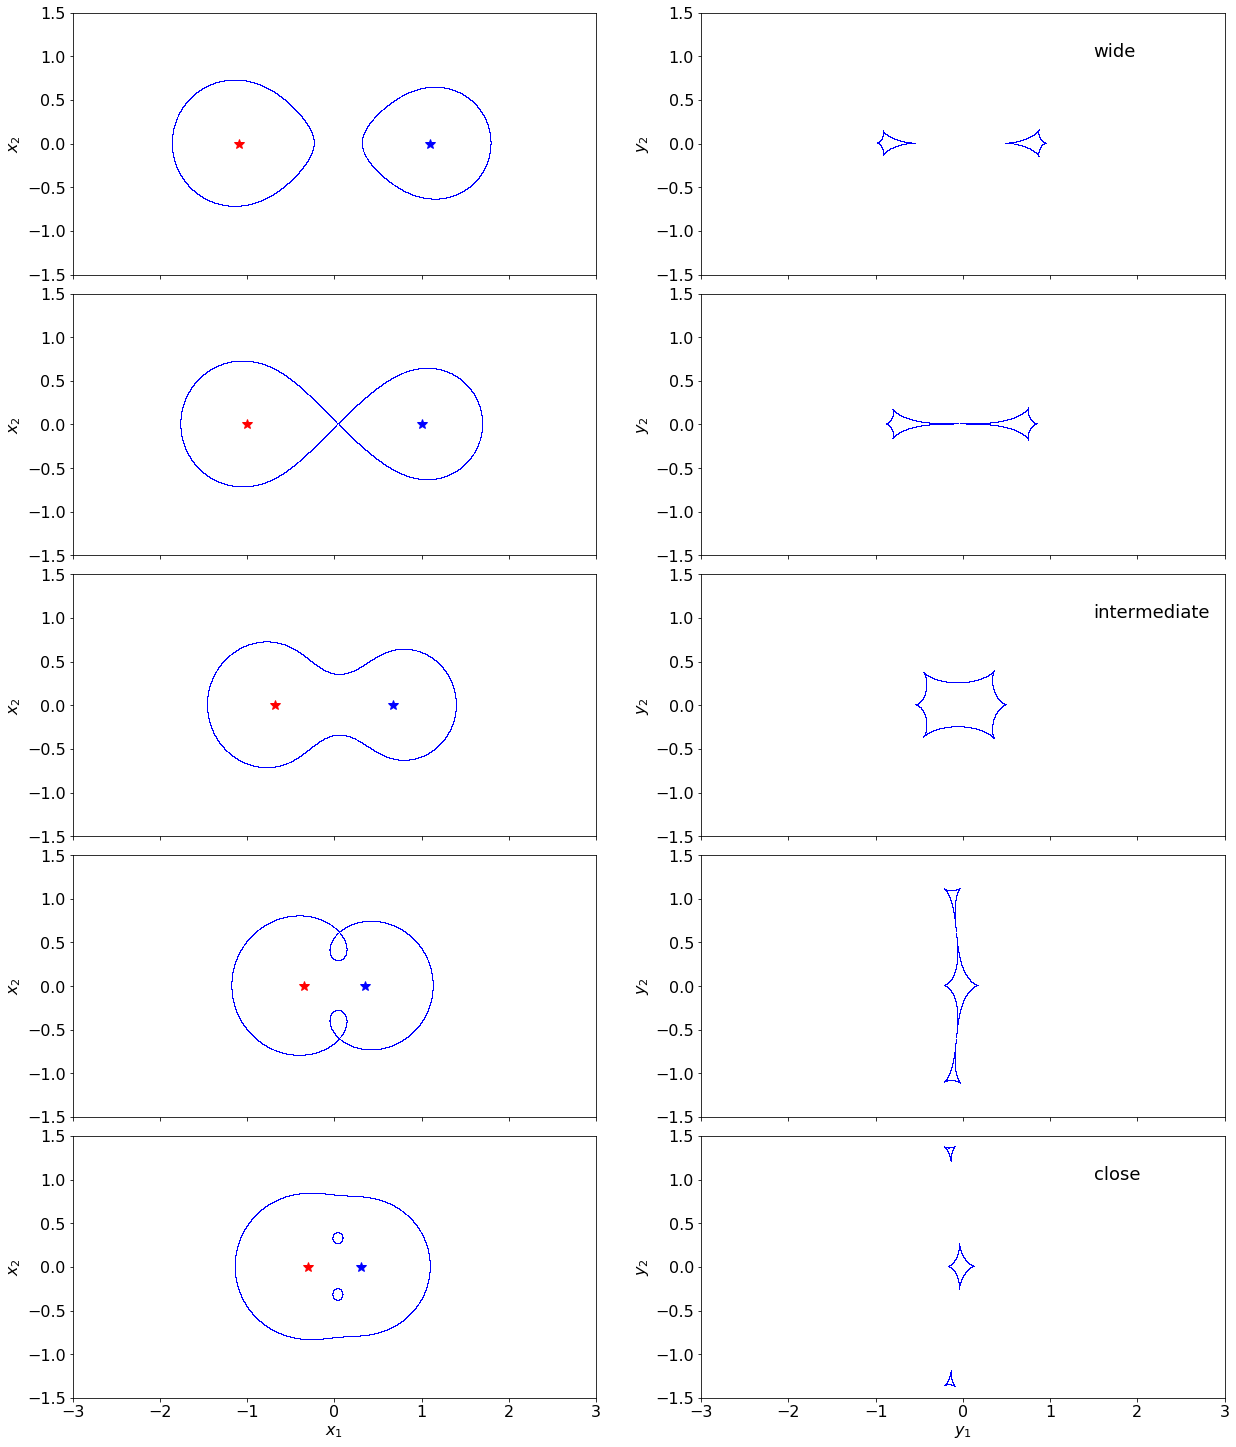

In [4]:
m1=1.0
q=0.8
m2=m1/q
mtot=m1+m2
dwi=((m1/mtot)**(1./3.)+(m2/mtot)**(1./3.))**(3./2.)
dic=((m1/mtot)**(1./3.)+(m2/mtot)**(1./3.))**(-3./4.)

d=[dwi+0.2,dwi,0.5*(dwi+dic),dic,dic-0.1]

fig,ax=plt.subplots(len(d),2,figsize=(20,25),sharex=True)
desired_box_ratioN=0.5
for i in range(len(d)):
    bl=binary_lens(m1=1.0,q=q,d=d[i])
    x1,x2,xs1,xs2=bl.CritCau()

    ax[i,0].plot(x1,x2,',',color='blue')
    ax[i,1].plot(xs1,xs2,',',color='blue')

    # the positions of the two lenses
    z1=bl.getPos()
    z2=-z1
    ax[i,0].plot([z1.real],[z1.imag],'*',markersize=10,color='blue')
    ax[i,0].plot([z2.real],[z2.imag],'*',markersize=10,color='red')
    
    ax[i,0].xaxis.set_tick_params(labelsize=16)
    ax[i,0].yaxis.set_tick_params(labelsize=16)
    ax[i,1].xaxis.set_tick_params(labelsize=16)
    ax[i,1].yaxis.set_tick_params(labelsize=16)    

    #ax[i,0].set_xlabel('$x_1$',fontsize=16)
    ax[i,0].set_ylabel('$x_2$',fontsize=16)     
    #ax[i,1].set_xlabel('$y_1$',fontsize=16)
    ax[i,1].set_ylabel('$y_2$',fontsize=16) 
    
    xlim=np.array([-3.0,3.0])
    ylim=xlim/2.0
    ax[i,0].set_xlim(xlim)
    ax[i,0].set_ylim(ylim)
    ax[i,1].set_xlim(xlim)
    ax[i,1].set_ylim(ylim)
    
    temp_inverse_axis_ratioN = abs( (ax[i,0].get_xlim()[1] - ax[i,0].get_xlim()[0])/(ax[i,0].get_ylim()[1] - ax[i,0].get_ylim()[0]) )
    ax[i,0].set(aspect = desired_box_ratioN * temp_inverse_axis_ratioN, adjustable='box-forced')
    ax[i,1].set(aspect = desired_box_ratioN * temp_inverse_axis_ratioN, adjustable='box-forced')
    #ax[i,0].set(aspect=0.5)
    #ax[i,1].set(aspect=0.5)
    
fig.subplots_adjust(left=0.1,bottom=0.1)
ax[len(d)-1,0].set_xlabel('$x_1$',fontsize=16)
ax[len(d)-1,1].set_xlabel('$y_1$',fontsize=16)
fig.subplots_adjust(hspace=0)  
ax[0,1].text(1.5,1,'wide',fontsize=18)
ax[2,1].text(1.5,1,'intermediate',fontsize=18)
ax[4,1].text(1.5,1,'close',fontsize=18)
fig.savefig('binary_cc.png')


# Multiple images

To find the positions of the images of a source at $z_s$, we can turn the lens equation into a 5-th order complex polynomial and find its roots using the same method used to find the critical points.

The polynomial can be written as:
$$
p_5(z)=\sum_{i=0}^{5}c_i z^i
$$
and, after setting 
$$
\Delta m= \frac{m_1-m_2}{2} \hspace{1cm}  m=\frac{m_1+m_2}{2} \hspace{1cm} z_2=-z_1 \hspace{1cm} z_1=z_1^* \;,
$$
the coefficients turn out to be
$$
c_0=z_1^2[4(\Delta m)^2 z_s+4m\Delta m z_1 +4 \Delta m z_s z_s^* z_1 +2mz_s^*z_1^2+z_sz_s^{*2}z_1^2-2\Delta m z_1^3-z_sz_1^4] \\
c_1=-8m\Delta m z_s z_1 - 4 (\Delta m)^2z_1^2-4m^2z_1^2-4mz_sz_s^*z_1^2-4\Delta m z_s^*z_1^3-z_s^{*2}z_1^4+z_1^6 \\
c_2=4 m^2 z_s+4 m \Delta m z_1 -4 \Delta m z_s z_s^* z_1 -2 z_s z_s^{*2}z_1^2 + 4 \Delta m z_1^3+2z_sz_1^4 \\
c_3 = 4m z_s z_s^*+4 \Delta m z_s^* z_1+2 z_s^{*2}z_1^2-2z_1^4 \\
c_4 = -2mz_s^*+z_sz_s^{*2}-2\Delta m z_1 - z_s z_1^2 \\
c_5 = z_1^2-z_s^{*2}
$$

[  8.88178420e-16   3.78942392e-15   1.02357505e-15   6.72627626e-01
   6.72627626e-01]


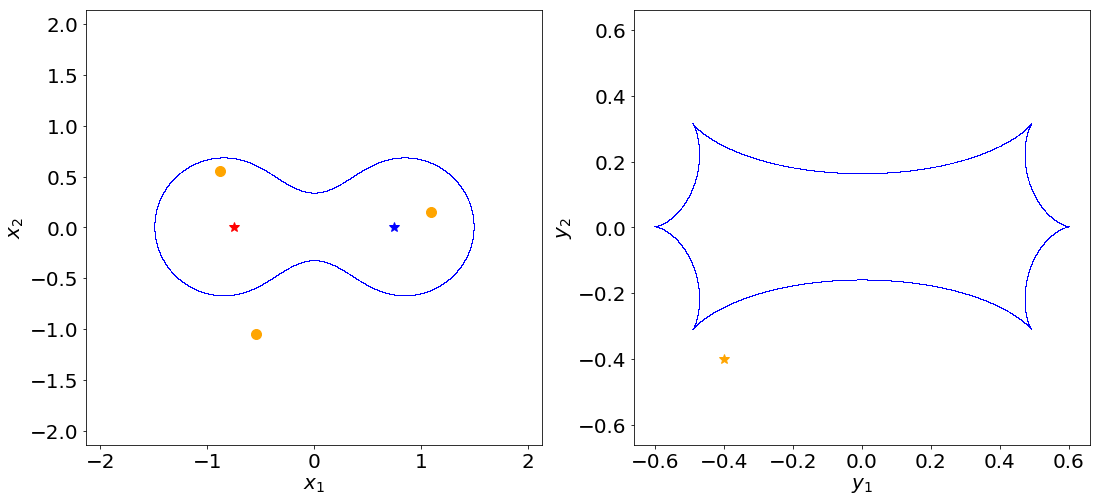

In [8]:
bl=binary_lens(m1=1.0,q=1.0,d=1.5)
x1,x2,xs1,xs2=bl.CritCau()

ys1,ys2=-0.4,-0.4
xi1,xi2=bl.Images(ys1,ys2)


###############################################################################

fig,ax=plt.subplots(1,2,figsize=(18,8))

# plot the results
ax[0].plot(x1,x2,',',color='blue')
ax[1].plot(xs1,xs2,',',color='blue')
z1=bl.getPos()
z2=-z1
ax[0].plot([z1.real],[z1.imag],'*',markersize=10,color='blue')
ax[0].plot([z2.real],[z2.imag],'*',markersize=10,color='red')

# set dimensions of image plane plotting area
xmin=np.amin(x1)
xmax=np.amax(x1)
ymin=np.amin(x2)
ymax=np.amax(x2)
dim=[xmax-xmin,ymax-ymin]
if (dim[0]>dim[1]):
    side=dim[0]*1.1
else:
    side=dim[1]*1.1

    
xmin_=0.5*(xmin+xmax)-1.3*side/2.0
xmax_=0.5*(xmin+xmax)+1.3*side/2.0
ymin_=0.5*(ymin+ymax)-1.3*side/2.0
ymax_=0.5*(ymin+ymax)+1.3*side/2.0


ax[0].set_xlim([xmin_,xmax_])
ax[0].set_ylim([ymin_,ymax_])

# set dimensions of source plane plotting area
xmin=np.amin(xs1)
xmax=np.amax(xs1)
ymin=np.amin(xs2)
ymax=np.amax(xs2)
dim=[xmax-xmin,ymax-ymin]
if (dim[0]>dim[1]):
    side=dim[0]*1.1
else:
    side=dim[1]*1.1

    
xmin_=0.5*(xmin+xmax)-side/2.0
xmax_=0.5*(xmin+xmax)+side/2.0
ymin_=0.5*(ymin+ymax)-side/2.0
ymax_=0.5*(ymin+ymax)+side/2.0

ax[1].set_xlim([xmin_,xmax_])
ax[1].set_ylim([ymin_,ymax_])

ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)    

ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)     
ax[1].set_xlabel('$y_1$',fontsize=20)
ax[1].set_ylabel('$y_2$',fontsize=20)

ax[1].plot(ys1,ys2,'*',markersize=10,color='orange')
ax[0].plot(xi1,xi2,'o',markersize=10,color='orange')



We can put the source on a trajectory to see how the image positions change as a function of time:

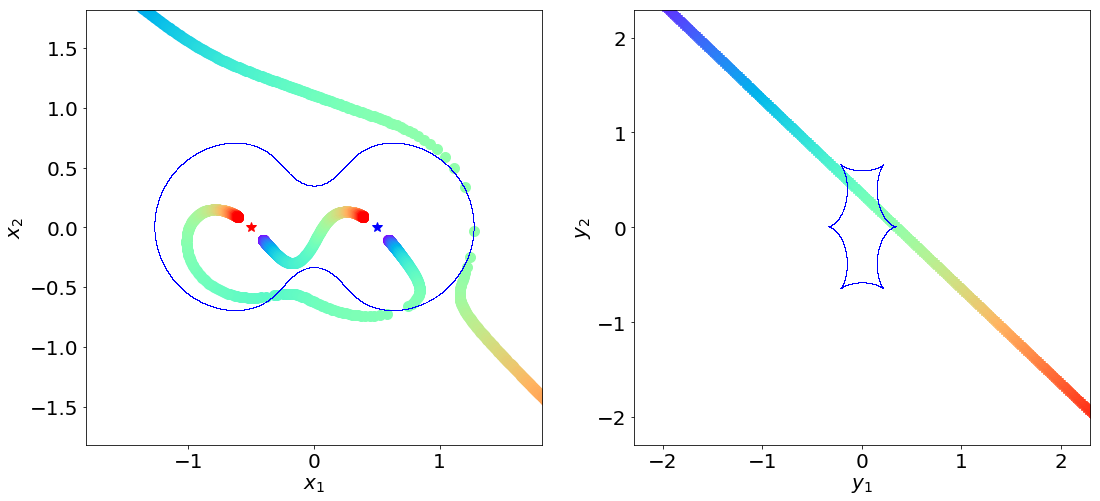

In [16]:
from matplotlib.pyplot import cm 

times=np.linspace(-165,165,730)
bl=binary_lens(m1=1.0,q=1.0,d=1.,t0=0.0,y0=0.25,theta=np.pi/4.)
x1,x2,xs1,xs2=bl.CritCau()

color=iter(cm.rainbow(np.linspace(0,1,times.size)))

fig,ax=plt.subplots(1,2,figsize=(18,8))


for t in times:
    c=next(color)
    ys1,ys2=bl.SourcePos(t)
    xi1,xi2=bl.Images(ys1,ys2)
    ax[1].plot(ys1,ys2,'*',markersize=10,color=c)
    ax[0].plot(xi1,xi2,'o',markersize=10,color=c)

ax[0].plot(x1,x2,',',color='blue')
ax[1].plot(xs1,xs2,',',color='blue')
#################################################################
    
z1=bl.getPos()
z2=-z1
ax[0].plot([z1.real],[z1.imag],'*',markersize=10,color='blue')
ax[0].plot([z2.real],[z2.imag],'*',markersize=10,color='red')

# set dimensions of image plane plotting area
xmin=np.amin(x1)
xmax=np.amax(x1)
ymin=np.amin(x2)
ymax=np.amax(x2)
dim=[xmax-xmin,ymax-ymin]
if (dim[0]>dim[1]):
    side=dim[0]*1.1
else:
    side=dim[1]*1.1

    
xmin_=0.5*(xmin+xmax)-1.3*side/2.0
xmax_=0.5*(xmin+xmax)+1.3*side/2.0
ymin_=0.5*(ymin+ymax)-1.3*side/2.0
ymax_=0.5*(ymin+ymax)+1.3*side/2.0


ax[0].set_xlim([xmin_,xmax_])
ax[0].set_ylim([ymin_,ymax_])

# set dimensions of source plane plotting area
xmin=np.amin(xs1)
xmax=np.amax(xs1)
ymin=np.amin(xs2)
ymax=np.amax(xs2)
dim=[xmax-xmin,ymax-ymin]
if (dim[0]>dim[1]):
    side=dim[0]*3.5
else:
    side=dim[1]*3.5

    
xmin_=0.5*(xmin+xmax)-side/2.0
xmax_=0.5*(xmin+xmax)+side/2.0
ymin_=0.5*(ymin+ymax)-side/2.0
ymax_=0.5*(ymin+ymax)+side/2.0

ax[1].set_xlim([xmin_,xmax_])
ax[1].set_ylim([ymin_,ymax_])

ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)    

ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)     
ax[1].set_xlabel('$y_1$',fontsize=20)
ax[1].set_ylabel('$y_2$',fontsize=20)

#fig.savefig('bl_multima.png')

# Magnification

As in the case of microlensing by single lenses, multiple images remain undetected and the binary microlensing can be revealed only by means of the magnification effects (photometric and astrometric microlensing).

The magnification of each image can be computed using the formula:
$$
\det A = 1-\left|\sum_{i=1}^{2}\frac{m_i}{(z^*-z_i^*)^2}\right|
$$
remembering that $\mu=\det A^{-1}$.

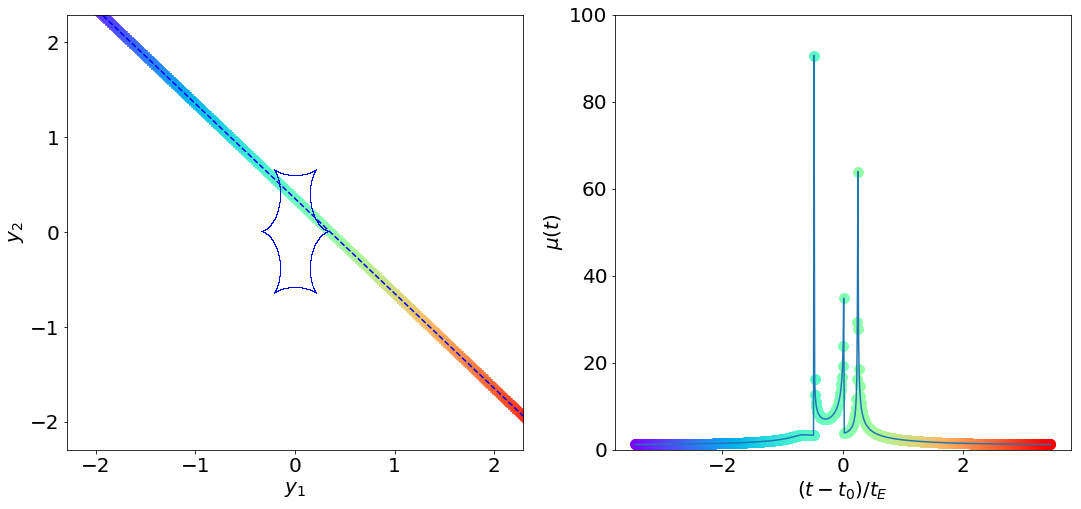

In [17]:
p,mu=bl.LightCurve(times)

fig,ax=plt.subplots(1,2,figsize=(18,8))

color=iter(cm.rainbow(np.linspace(0,1,times.size)))
ys1,ys2=bl.SourcePos(times)
for i in range(times.size):
    c=next(color)
    #ys1,ys2=bl.SourcePos(times[i])
    ax[0].plot(ys1[i],ys2[i],'*',markersize=10,c=c)
    ax[1].plot([p[i]],[mu[i]],'o',markersize=10,c=c)

####################################################################
    
ax[0].plot(ys1,ys2,'--',color='blue')
ax[1].plot(p,mu,'-')
ax[1].set_ylim([0.0,100])
ax[0].set_xlim([xmin_,xmax_])
ax[0].set_ylim([ymin_,ymax_])

ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)

ax[0].set_xlabel('$y_1$',fontsize=20)
ax[0].set_ylabel('$y_2$',fontsize=20)

ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[1].set_xlabel('$(t-t_0)/t_E$',fontsize=20)
ax[1].set_ylabel('$\mu(t)$',fontsize=20)
ax[0].plot(xs1,xs2,',',color='blue')

#fig.savefig('bl_lightcurve.png')